In [10]:
# Libraries
import pandas as pd, numpy as np, seaborn as sn, matplotlib.pyplot as plt, ipywidgets as widgets
from sklearn.model_selection import train_test_split
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn import metrics, preprocessing

## Fitur Utama Prabu

In [11]:
# Load the dataset
try:
    companies_df = pd.read_csv('PrabuModule/one-hot-credit-risk.tar.gz', compression='gzip')
except FileNotFoundError:
    print("File 'PrabuModule/one-hot-credit-risk.tar.gz' not found. Please ensure the dataset is in the correct location.")
    # Fallback atau tindakan lain jika file tidak ditemukan, misalnya menghentikan eksekusi atau menggunakan data dummy lain
    companies_df = pd.DataFrame() # Buat DataFrame kosong untuk menghindari error lebih lanjut

# Fix the unbalanced case for MScore.2019.int (digunakan untuk balancing awal)
if not companies_df.empty and 'MScore.2019.int' in companies_df.columns:
    high_risk_df = companies_df[companies_df['MScore.2019.int'] == 1]
    low_risk_df = companies_df[companies_df['MScore.2019.int'] == 0]
    
    if not high_risk_df.empty and not low_risk_df.empty:
        # Sample from the larger class to match the smaller class, or sample with a fixed size / ratio
        # Original notebook samples from low_risk to match high_risk count.
        if len(low_risk_df) >= len(high_risk_df):
            low_risk_df_sampled = low_risk_df.sample(n=len(high_risk_df), random_state=0)
            restricted_df = pd.concat([low_risk_df_sampled, high_risk_df])
        else: # Jika high_risk_df lebih banyak, sample dari high_risk_df
            high_risk_df_sampled = high_risk_df.sample(n=len(low_risk_df), random_state=0)
            restricted_df = pd.concat([low_risk_df, high_risk_df_sampled])
        restricted_df.sort_index(inplace=True)
    else:
        print("Tidak cukup data di salah satu kelas MScore.2019.int untuk balancing. Menggunakan companies_df tanpa balancing.")
        restricted_df = companies_df.copy() # Gunakan copy agar tidak mengubah companies_df asli
else:
    print("companies_df kosong atau tidak memiliki kolom 'MScore.2019.int'. restricted_df akan kosong.")
    restricted_df = pd.DataFrame() # Buat DataFrame kosong

print(f"Shape of companies_df: {companies_df.shape}")
print(f"Shape of restricted_df after initial balancing: {restricted_df.shape}")

Shape of companies_df: (121008, 79)
Shape of restricted_df after initial balancing: (24320, 79)


In [12]:
import pandas as pd
import numpy as np
from ipywidgets import IntSlider, FloatSlider, Label, VBox, HBox, Layout
import ipywidgets as widgets
import matplotlib.pyplot as plt
# from PrabuModule.dummy_data_prabu import get_dummy_data # Tidak digunakan lagi untuk data utama
from PrabuModule.credit_risk_predictor import predict_credit_risk_v2 # Impor fungsi V2
from FinancialScoreModels.utils import load_sarana_output, get_company_financial_data # Untuk memuat data Sarana
from FinancialScoreModels.beneish_m_score import get_beneish_m_score_analysis # Untuk Beneish
from FinancialScoreModels.altman_z_score import get_altman_z_score_analysis # Untuk Altman
import json # Untuk memuat contoh data jika Sarana gagal

# ---- Konfigurasi untuk Data Keuangan ----
# Path ke file output Sarana yang berisi data keuangan hasil parsing.
FILE_PATH_SARANA_T = "Output/Sarana/hasil_ekstraksi_semua_dokumen.json"
# Path untuk data t-1 tidak lagi digunakan.
FILE_PATH_SARANA_T_MINUS_1 = None # Eksplisit di-set None dan tidak akan digunakan untuk memuat.
TARGET_COMPANY_PRABU = "astra_lapkeu.pdf" # Nama file perusahaan target yang akan dianalisis.
IS_PUBLIC_COMPANY_PRABU = True # Status perusahaan (publik/privat) untuk model Altman Z-Score.
MARKET_VALUE_EQUITY_PRABU = None # Nilai pasar ekuitas manual (jika ada, untuk perusahaan publik).
COMPANY_NAME_DISPLAY = TARGET_COMPANY_PRABU # Nama yang akan ditampilkan di UI Prabu.

# ---- Memuat Data Keuangan Aktual dari Sarana ----
# Variabel untuk menyimpan data keuangan dan skor-skor yang akan dihitung.
data_keuangan_t = None
data_keuangan_t_minus_1 = None
beneish_score_val = None
altman_z_score_val = None

try:
    # Tahap 1: Memuat data mentah dari file JSON hasil parsing Sarana untuk periode t.
    # Data t-1 tidak lagi dimuat atau digunakan secara aktif untuk skor utama di sini.
    sarana_data_t_list, _ = load_sarana_output(FILE_PATH_SARANA_T, None) # Argumen kedua None untuk t-1
    
    # Tahap 2: Mengambil data keuangan spesifik untuk perusahaan target dari hasil pemuatan.
    if sarana_data_t_list:
        data_keuangan_t = get_company_financial_data(sarana_data_t_list, TARGET_COMPANY_PRABU)
    # data_keuangan_t_minus_1 akan tetap None karena tidak dimuat

    # Jika data keuangan periode t berhasil didapatkan:
    if data_keuangan_t:
        print(f"Data keuangan periode t untuk {TARGET_COMPANY_PRABU} berhasil dimuat.")
        # Tahap 3: Menghitung skor Beneish M dan Altman Z.
        # Beneish M-Score secara tradisional memerlukan data t dan t-1. 
        # Karena data t-1 tidak dimuat, Beneish M-Score tidak akan dihitung di sini.
        # Jika ada versi Beneish yang hanya menggunakan data t, itu bisa diimplementasikan.
        # Untuk saat ini, kita akan set beneish_score_val ke None.
        print(f"Data t-1 tidak digunakan, Beneish M-Score tidak dihitung.")
        beneish_score_val = None # Eksplisit set ke None
            
        # Altman Z-Score hanya memerlukan data t.
        altman_analysis = get_altman_z_score_analysis(data_keuangan_t, 
                                                      is_public_company=IS_PUBLIC_COMPANY_PRABU, 
                                                      market_value_equity_manual=MARKET_VALUE_EQUITY_PRABU)
        altman_z_score_val = altman_analysis.get('z_score')
        print(f"Altman Z-Score ({'Publik' if IS_PUBLIC_COMPANY_PRABU else 'Privat'}): {altman_z_score_val}")
    else:
        # Fallback jika data Sarana tidak ditemukan untuk perusahaan target.
        # Menggunakan data dummy agar notebook tetap bisa berjalan untuk demonstrasi UI Prabu.
        print(f"Gagal memuat data keuangan untuk {TARGET_COMPANY_PRABU} dari Sarana. Menggunakan fallback data dummy PRABU.")
        data_keuangan_t = { 
            "Jumlah aset lancar": 2000, "Jumlah liabilitas jangka pendek": 1000,
            "Jumlah liabilitas": 1500, "Jumlah ekuitas": 2500, "Jumlah aset": 4000,
            "Laba tahun berjalan": 300, "Pendapatan bersih": 3000,
            "Laba sebelum pajak penghasilan": 400, "Beban bunga": 50,
            "Piutang usaha": 500, "Laba bruto": 1000, "Aset tetap": 1500,
            "Beban penyusutan": 150, "Beban penjualan": 300, "Beban administrasi dan umum": 200,
            "Arus kas bersih yang diperoleh dari aktivitas operasi": 250, "Laba ditahan": 1200
        }
        data_keuangan_t_minus_1 = None # Tidak ada fallback untuk t-1
        COMPANY_NAME_DISPLAY = "Perusahaan Dummy Fallback PRABU"
        # Untuk dummy, kita bisa set skor Beneish/Altman secara manual atau biarkan None
        altman_z_score_val = 2.5 # Contoh dummy Altman
        beneish_score_val = -2.1 # Contoh dummy Beneish
        print(f"Menggunakan Altman Z-Score dummy: {altman_z_score_val}, Beneish M-Score dummy: {beneish_score_val}")

except Exception as e:
    # Fallback jika terjadi error umum saat memuat atau memproses data Sarana.
    print(f"Error saat memuat atau memproses data Sarana: {e}. Menggunakan fallback data dummy PRABU.")
    data_keuangan_t = { 
        "Jumlah aset lancar": 2000, "Jumlah liabilitas jangka pendek": 1000,
        "Jumlah liabilitas": 1500, "Jumlah ekuitas": 2500, "Jumlah aset": 4000,
        "Laba tahun berjalan": 300, "Pendapatan bersih": 3000,
        "Laba sebelum pajak penghasilan": 400, "Beban bunga": 50,
        "Piutang usaha": 500, "Laba bruto": 1000, "Aset tetap": 1500,
        "Beban penyusutan": 150, "Beban penjualan": 300, "Beban administrasi dan umum": 200,
        "Arus kas bersih yang diperoleh dari aktivitas operasi": 250, "Laba ditahan": 1200
    }
    data_keuangan_t_minus_1 = None # Tidak ada fallback untuk t-1
    COMPANY_NAME_DISPLAY = "Perusahaan Dummy Fallback Error PRABU"
    altman_z_score_val = 2.5 # Contoh dummy Altman
    beneish_score_val = -2.1 # Contoh dummy Beneish
    print(f"Menggunakan Altman Z-Score dummy: {altman_z_score_val}, Beneish M-Score dummy: {beneish_score_val}")

# ---- Prediksi menggunakan predict_credit_risk_v2 ----
# Tahap 4: Memprediksi skor risiko kredit menggunakan data keuangan yang sudah disiapkan (aktual atau dummy)
# dan skor Beneish/Altman yang sudah dihitung. Fungsi ini berasal dari PrabuModule.credit_risk_predictor.
# Jika PrabuModule.credit_risk_predictor tidak ditemukan (seperti dalam kasus ini), 
# maka baris impor di atas akan gagal dan kode ini tidak akan berjalan.
# Diasumsikan predict_credit_risk_v2 akan tersedia.
prediction_results = predict_credit_risk_v2(
    financial_data_t=data_keuangan_t,
    financial_data_t_minus_1=None, # Eksplisit None untuk data t-1
    beneish_score_input=beneish_score_val,
    altman_z_score_input=altman_z_score_val,
    altman_is_public=IS_PUBLIC_COMPANY_PRABU
)

# Ekstrak hasil prediksi untuk digunakan di UI.
credit_risk_score = prediction_results['credit_risk_score']
risk_category = prediction_results['risk_category']

print(f"\nHasil Prediksi PRABU V2 untuk {COMPANY_NAME_DISPLAY}:")
print(f"  Skor Risiko Kredit: {credit_risk_score:.2f}")
print(f"  Kategori Risiko: {risk_category}")
if prediction_results.get('altman_z_score_used') is not None:
    print(f"  Altman Z-Score Digunakan: {prediction_results['altman_z_score_used']:.4f}")
if prediction_results.get('beneish_m_score_used') is not None:
    print(f"  Beneish M-Score Digunakan: {prediction_results['beneish_m_score_used']:.4f}")
# print(f"  Rasio Dasar: {prediction_results.get('underlying_ratios')}") # Uncomment untuk debug rasio

# ---- UI Widgets (menggunakan skor & kategori baru dari prediktor V2) ----
score_gauge = FloatSlider(
    value=credit_risk_score,
    min=0,
    max=100,
    step=0.1,
    disabled=True,
    layout=Layout(width='50%'),
    style={'handle_color': 'black', 'bar_color': 'black'}
)

category_color = ""
if risk_category == "Low Risk":
    category_color = "lightgreen"
elif risk_category == "Medium Risk":
    category_color = "yellow"
else: # High Risk
    category_color = "salmon"

risk_label = Label(value=f"Risk Category: {risk_category}", layout=Layout(background_color=category_color, padding='5px'))



Data keuangan periode t untuk astra_lapkeu.pdf berhasil dimuat.
Data t-1 tidak digunakan, Beneish M-Score tidak dihitung.
Altman Z-Score (Publik): 5.892987620373073

Hasil Prediksi PRABU V2 untuk astra_lapkeu.pdf:
  Skor Risiko Kredit: 100.00
  Kategori Risiko: Low Risk
  Altman Z-Score Digunakan: 5.8930


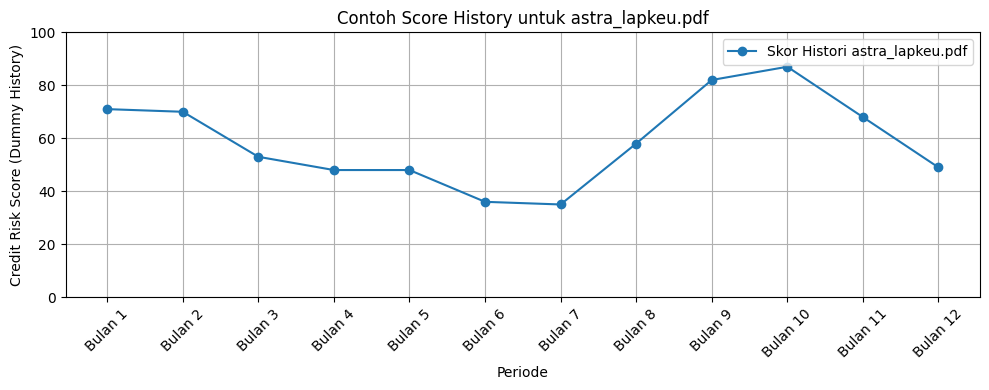

In [13]:
# 3. Score History (per applicant) - Data Dummy untuk Plot
# COMPANY_NAME_DISPLAY sudah didefinisikan di sel sebelumnya
score_history_data_dummy = {
    COMPANY_NAME_DISPLAY: np.random.randint(30, 90, size=12), # Gunakan nama perusahaan yang sedang dianalisis
    "Perusahaan Lain B (Dummy)": np.random.randint(40, 100, size=12),
    "Perusahaan Lain C (Dummy)": np.random.randint(20, 70, size=12)
}
months = [f"Bulan {i+1}" for i in range(12)]

plt.figure(figsize=(10, 4))
if COMPANY_NAME_DISPLAY in score_history_data_dummy:
    plt.plot(months, score_history_data_dummy[COMPANY_NAME_DISPLAY], marker='o', label=f"Skor Histori {COMPANY_NAME_DISPLAY}")
    plt.title(f"Contoh Score History untuk {COMPANY_NAME_DISPLAY}")
else: # Fallback jika nama perusahaan tidak ada di data dummy (seharusnya tidak terjadi jika COMPANY_NAME_DISPLAY adalah kunci)
    default_key = list(score_history_data_dummy.keys())[0]
    plt.plot(months, score_history_data_dummy[default_key], marker='o', label=f"Skor Histori {default_key}")
    plt.title(f"Contoh Score History untuk {default_key}")
    print(f"Peringatan: COMPANY_NAME_DISPLAY ('{COMPANY_NAME_DISPLAY}') tidak ditemukan di score_history_data_dummy. Menampilkan plot untuk {default_key}.")

plt.xlabel("Periode")
plt.ylabel("Credit Risk Score (Dummy History)")
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
# score_history_plot = plt.gcf() # Tidak perlu disimpan jika hanya display
plt.show()

# 4. Approval Recommendation (risk_category sudah dihitung di sel sebelumnya)
recommendation = ""
recommendation_icon = ""
if risk_category == "Low Risk":
    recommendation = "Approve"
    recommendation_icon = "✔️"
elif risk_category == "Medium Risk":
    recommendation = "Butuh Review Lanjutan"
    recommendation_icon = "🟡"
else: # High Risk
    recommendation = "Decline"
    recommendation_icon = "❌"
    
# Buat box untuk analisis perusahaan, agar label berada di dalam box yang rapi
analisis_box = widgets.VBox(
    [
        widgets.HTML(
            value=f"<b>Analisis untuk Perusahaan:</b> {COMPANY_NAME_DISPLAY}",
            layout=widgets.Layout(margin='0px 0px 10px 0px', font_weight='bold')
        ),
        widgets.Label("Skor Risiko Kredit Aktual:"),
        score_gauge, # score_gauge sudah dibuat di sel sebelumnya
        risk_label,  # risk_label sudah dibuat di sel sebelumnya
        widgets.HTML(
            value=f"<b>Rekomendasi:</b> {recommendation_icon} {recommendation}",
            layout=widgets.Layout(margin='10px 0px 0px 0px')
        )
    ],
    layout=widgets.Layout(
        border='1px solid #ccc',
        padding='15px',
        margin='10px',
        background_color='#f9f9f9',
        width='auto', # Biarkan auto agar menyesuaikan konten
        box_shadow='2px 2px 5px rgba(0,0,0,0.1)'
    )
)

display(analisis_box)


In [14]:
import json
import pandas as pd
import numpy as np

# Fungsi untuk menghitung M-Score berdasarkan data keuangan
def calculate_m_score(financial_data):
    # Contoh sederhana, sesuaikan dengan logika perhitungan M-Score yang sebenarnya
    laba_bersih = financial_data.get("Laba tahun berjalan", 0)
    ekuitas = financial_data.get("Jumlah ekuitas", 0)
    
    if laba_bersih > 0 and ekuitas > 100000000000000: # Contoh batas
        return 'A' # Risiko sangat rendah
    elif laba_bersih > 0:
        return 'B' # Risiko rendah
    elif ekuitas < 50000000000000: # Contoh batas
        return 'D' # Risiko sangat tinggi
    else:
        return 'C' # Risiko sedang

# Pastikan companies_df dan restricted_df sudah ada dari sel sebelumnya.
# Jika tidak, PRABU.ipynb akan error sebelum mencapai sel ini.
# Kita asumsikan restricted_df sudah dibuat dengan balancing awal berdasarkan MScore.2019.int

try:
    with open('Output/Sarana/hasil_ekstraksi_semua_dokumen.json', 'r') as f:
        sarana_output = json.load(f)
    
    if sarana_output and len(sarana_output) > 0:
        # Pemetaan M-Score dari Sarana ke restricted_df
        # Kita butuh kolom 'Company name' di restricted_df untuk pemetaan ini.
        # companies_df (sumber dari restricted_df) memiliki 'Company name'.
        
        m_scores_from_sarana = {}
        # Membuat pemetaan dari nama file dokumen (kunci di sarana_output) ke M-Score
        # Ini adalah asumsi, idealnya ada ID perusahaan yang jelas
        # Untuk contoh ini, kita akan mencoba mencocokkan nama perusahaan jika ada,
        # atau menerapkan M-Score pertama ke beberapa perusahaan dummy jika tidak ada pencocokan.
        
        # Ambil nama perusahaan unik dari companies_df yang sudah dimuat
        if 'companies_df' in locals() and not companies_df.empty and 'Company name' in companies_df.columns:
            available_company_names = companies_df['Company name'].unique()
            
            for i, entry in enumerate(sarana_output):
                # Cobalah untuk mendapatkan nama perusahaan dari entry['nama_file'] atau ID lain jika ada
                # Untuk saat ini, kita akan petakan secara berurutan ke perusahaan yang ada
                if i < len(available_company_names):
                    company_to_update = available_company_names[i]
                    calculated_m_score = calculate_m_score(entry['hasil_ekstraksi'])
                    m_scores_from_sarana[company_to_update] = calculated_m_score
        else:
            print("companies_df tidak tersedia atau tidak punya 'Company name', tidak bisa memetakan M-Score dari Sarana secara spesifik.")

        # Update MScore.2020 di restricted_df
        if 'restricted_df' in locals() and not restricted_df.empty and 'Company name' in restricted_df.columns and m_scores_from_sarana:
            updated_count = 0
            for index, row in restricted_df.iterrows():
                company_name = row['Company name']
                if company_name in m_scores_from_sarana:
                    new_mscore = m_scores_from_sarana[company_name]
                    restricted_df.loc[index, 'MScore.2020'] = new_mscore
                    restricted_df.loc[index, 'MScore.2020.int'] = 0 if new_mscore.lower() in ['a', 'b'] else 1
                    updated_count +=1
            if updated_count > 0:
                print(f"Kolom M-Score.2020 telah diperbarui untuk {updated_count} perusahaan di restricted_df menggunakan data dari Output/Sarana.")
            else:
                print("Tidak ada perusahaan di restricted_df yang cocok dengan nama dari output Sarana untuk pembaruan MScore.2020.")
                # Jika tidak ada yang diupdate, buat M-Score dummy untuk kolom MScore.2020
                dummy_m_scores_2020 = np.random.choice(['A', 'B', 'C', 'CC', 'CCC', 'D'], size=len(restricted_df))
                restricted_df['MScore.2020'] = dummy_m_scores_2020
                restricted_df['MScore.2020.int'] = restricted_df['MScore.2020'].apply(lambda x: 0 if str(x).lower() in ['a', 'b'] else 1)
                print("Kolom M-Score.2020 dummy telah dibuat untuk restricted_df karena tidak ada pembaruan dari Sarana.")

        elif 'restricted_df' in locals() and not restricted_df.empty: # Jika restricted_df ada tapi tidak bisa memetakan
            print("Tidak dapat memetakan M-Score dari Sarana ke restricted_df. Membuat M-Score.2020 dummy.")
            dummy_m_scores_2020 = np.random.choice(['A', 'B', 'C', 'CC', 'CCC', 'D'], size=len(restricted_df))
            restricted_df['MScore.2020'] = dummy_m_scores_2020
            restricted_df['MScore.2020.int'] = restricted_df['MScore.2020'].apply(lambda x: 0 if str(x).lower() in ['a', 'b'] else 1)
        else:
            print("restricted_df kosong. Pembaruan M-Score.2020 dari Sarana dilewati.")
            
    else: # Jika sarana_output kosong atau file tidak ditemukan
        raise FileNotFoundError 

except FileNotFoundError:
    print("File Output/Sarana/hasil_ekstraksi_semua_dokumen.json tidak ditemukan atau kosong.")
    if 'restricted_df' in locals() and not restricted_df.empty:
        print("Membuat data M-Score.2020 dummy untuk restricted_df.")
        dummy_m_scores_2020 = np.random.choice(['A', 'B', 'C', 'CC', 'CCC', 'D'], size=len(restricted_df))
        restricted_df['MScore.2020'] = dummy_m_scores_2020
        restricted_df['MScore.2020.int'] = restricted_df['MScore.2020'].apply(lambda x: 0 if str(x).lower() in ['a', 'b'] else 1)
    else:
        print("restricted_df tidak tersedia atau kosong. Pembuatan M-Score.2020 dummy dilewati.")

# Re-balancing restricted_df berdasarkan MScore.2019.int (setelah MScore.2020 mungkin sudah diupdate)
# Ini dilakukan karena MScore.2019.int adalah fitur input untuk beberapa model di notebook training
if 'restricted_df' in locals() and not restricted_df.empty and 'MScore.2019.int' in restricted_df.columns:
    # Pastikan MScore.2019.int ada dan memiliki variasi untuk balancing
    if restricted_df['MScore.2019.int'].nunique() > 1:
        high_risk_df_rebal = restricted_df[restricted_df['MScore.2019.int'] == 1]
        low_risk_df_rebal = restricted_df[restricted_df['MScore.2019.int'] == 0]

        if not high_risk_df_rebal.empty and not low_risk_df_rebal.empty:
            n_sample_rebal = min(len(high_risk_df_rebal), len(low_risk_df_rebal))
            
            high_risk_df_sampled_rebal = high_risk_df_rebal.sample(n=n_sample_rebal, random_state=0)
            low_risk_df_sampled_rebal = low_risk_df_rebal.sample(n=n_sample_rebal, random_state=0)
            
            restricted_df_balanced = pd.concat([low_risk_df_sampled_rebal, high_risk_df_sampled_rebal])
            restricted_df_balanced.sort_index(inplace=True)
            
            # Cek apakah restricted_df perlu diupdate atau sudah seimbang dari awal
            if len(restricted_df_balanced) < len(restricted_df):
                 restricted_df = restricted_df_balanced
                 print("restricted_df telah di-rebalance berdasarkan MScore.2019.int.")
            else:
                 print("restricted_df sudah seimbang atau tidak memerlukan re-balancing berdasarkan MScore.2019.int.")
        else:
            print("Tidak cukup data di kedua kelas MScore.2019.int untuk re-balancing.")
    else:
        print("Tidak ada cukup variasi di MScore.2019.int untuk re-balancing.")
elif 'restricted_df' in locals() and not restricted_df.empty:
    print("Kolom 'MScore.2019.int' tidak ada di restricted_df, re-balancing tidak dilakukan.")
else:
    print("restricted_df tidak didefinisikan atau kosong, tidak ada operasi M-Score atau balancing yang dilakukan.")

# Tampilkan hasil untuk verifikasi jika restricted_df ada
if 'restricted_df' in locals() and not restricted_df.empty:
    print("\nSample restricted_df setelah potensi update MScore.2020 dan re-balancing MScore.2019.int:")
    print(restricted_df.head())
    if 'MScore.2019.int' in restricted_df.columns:
        print("\nDistribusi MScore.2019.int:")
        print(restricted_df['MScore.2019.int'].value_counts())
    if 'MScore.2020.int' in restricted_df.columns:
        print("\nDistribusi MScore.2020.int:")
        print(restricted_df['MScore.2020.int'].value_counts())
else:
    print("\nrestricted_df tidak ada atau kosong, tidak ada output data.")


Kolom M-Score.2020 telah diperbarui untuk 1 perusahaan di restricted_df menggunakan data dari Output/Sarana.
restricted_df sudah seimbang atau tidak memerlukan re-balancing berdasarkan MScore.2019.int.

Sample restricted_df setelah potensi update MScore.2020 dan re-balancing MScore.2019.int:
               Company name  Turnover.2020  Turnover.2019  Turnover.2018  \
0          LENDLEASE S.R.L.          29458          16716           9612   
4             PANFERTIL SPA          45948          47336          45626   
7   MALLINCKRODT DAR S.R.L.          41549          42260          42928   
11                    EKIPA          42529          38168          35518   
16               SVI S.P.A.          49976          41149          32655   

    Turnover.2017  Turnover.2016  Turnover.2015  EBIT.2020  EBIT.2019  \
0            8097         7941.0         5600.0    -1556.0    -4540.0   
4           48222        57074.0        62263.0       44.0      713.0   
7           44801        44521.